In [1]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

In [2]:
# utils.py

def make_quantiles(df, v, cat):
    data = (
        df
        .filter(region='World', variable=v)
        .filter(Category=cat)
        .quantiles((0.1, 0.25, 0.5, 0.75, 0.9))
    )
    data.set_meta(cat, name='Category')
    data = data.rename({'model': {'unweighted': cat}})
    return data

def make_sequestration_plot_data(df, variables, categories_to_temp, years=[2030, 2050]):
    # pyam version of quantile data
    data = pyam.concat([
        (
            df
            .filter(region='World', variable=variable)
            .filter(Category=category)
            .quantiles((0.25, 0.5, 0.75))
            .rename(model={'unweighted': temp})
        ) for (category, temp), variable in itertools.product(categories_to_temp.items(), variables)
    ])

    # data ready for plotting
    pdata = (
        data
        .filter(year=years)
        .as_pandas(meta_cols=False)
        .assign(index=lambda x: x.year.astype(str) + ' ' + x.model)
        .drop(columns=['region', 'unit', 'year', 'model'])
        .set_index(['index', 'scenario', 'variable'])
        ['value']
        .unstack(['scenario', 'variable'])
        / 1e3
    )
    pdata = pdata.reindex(index=pdata.index[::-1]) # reverse ordering so plots are in correct order
    return data, pdata

def sequestration_plot(pdata, order=None, medians=True, stacked=True, cmap='PiYG', ax=None, legend=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    
    base, mins, maxs = pdata['quantile_0.5'], pdata['quantile_0.25'], pdata['quantile_0.75']
    if order:
        base = base[order]
    errors = [[base[c] - mins[c], maxs[c] - base[c]] for c in base.columns]
    
    base.plot.barh(xerr=errors, capsize=4, rot=0, stacked=stacked, ax=ax, cmap=cmap, alpha=0.7)
    if medians:
        ax.scatter(base.sum(axis=1), base.index, marker='s', color='k', label='Median Total')
    
    h, l = ax.get_legend_handles_labels()
    start = -1 * len(pdata.columns.get_level_values('variable').unique())
    if medians:
        start -= 1
    legend = legend or pyam.plotting.OUTSIDE_LEGEND['bottom']
    ax.legend(h[start:], l[start:], **legend)
    return ax

# Load Data

In [3]:
data_path = pathlib.Path('../data')

In [4]:
LABEL = '2015_soft_grassi'

In [5]:
pddata = pd.read_csv(data_path / f'analysis_{LABEL}_data.csv')

In [6]:
df = pyam.IamDataFrame(pddata)
df.load_meta(data_path / f'analysis_{LABEL}_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators


In [7]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

# Panel 1A

In [8]:
variables = [
    'Emissions|CO2|AFOLU',
    'Emissions|CO2|AFOLU - Reanalyzed and Adjusted', 
    'Emissions|CO2|AFOLU - Reanalyzed',
]

data = pyam.concat([
    make_quantiles(df, v, cat)
    for v, cat in itertools.product(variables, categories_to_temp.keys())
])

In [9]:
def afolu_line_plot(data, variables, cat, ax=None, years=range(1990, 2051)):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.25*', '*0.75*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color='variable', fill_between=True, ax=ax, alpha=0.1, legend=False) #  cmap='PiYG_r',
    )
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.5*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color='variable', ax=ax)  # cmap='PiYG_r',
    )
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-len(variables):], l[-len(variables):])
    return ax

In [10]:
color_map = {
    'Emissions|CO2|AFOLU': '#' + 'c' * 6,
    'LULUCF Emissions - Reanalyzed': '#33701a',
    'LULUCF Emissions - NGHGI Correction': '#a3176d', 
}
pyam.run_control().update({'color': {'variable': color_map}})

Text(0.5, 0, '')

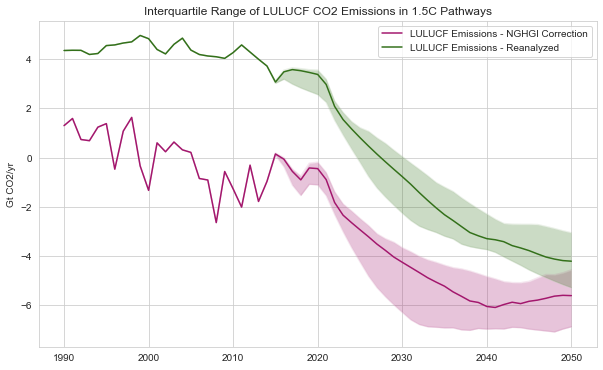

In [11]:
cat = 'C1'

variables = {
    'Emissions|CO2|AFOLU - Reanalyzed': 'LULUCF Emissions - Reanalyzed',
    'Emissions|CO2|AFOLU - Reanalyzed and Adjusted': 'LULUCF Emissions - NGHGI Correction', 
}
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')


## Additional Figures for SI

Text(0.5, 0, '')

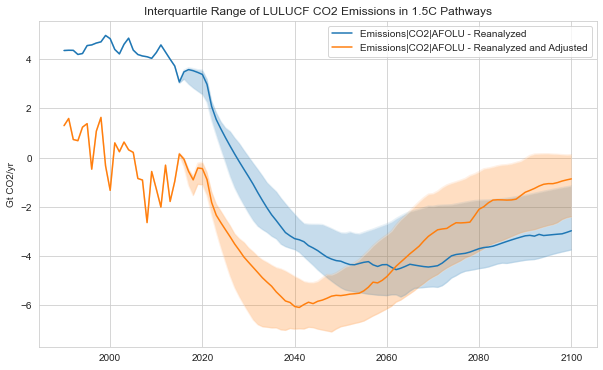

In [12]:
cat = 'C1'
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data, variables, cat, years=range(1990, 2101), ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')

Text(0.5, 0, '')

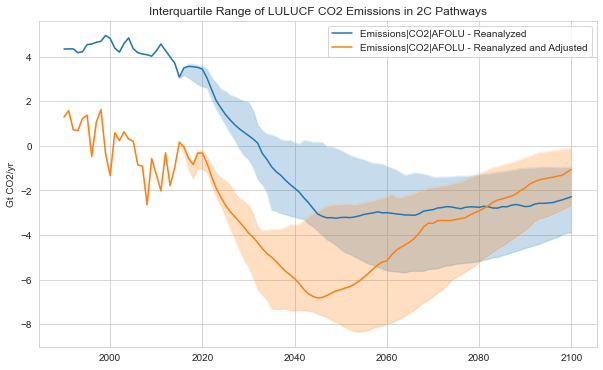

In [13]:
cat = 'C3'
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data, variables, cat, years=range(1990, 2101), ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')

# Panel 1B

Text(0.5, 0, '')

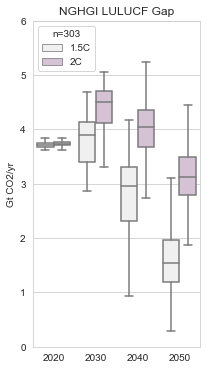

In [14]:
variables = [
    'Emissions|CO2|AFOLU - Reanalyzed',
    'Emissions|CO2|AFOLU - Reanalyzed and Adjusted', 
]
name = 'NGHGI LULUCF Gap'
fig, ax = plt.subplots(figsize=(3, 6))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2020, 2051, 10))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_title(name)
ax.set_ylim(0, 6)
ax.set_xlabel('')

# Panel 1C

In [15]:
variables = ['Cumulative Carbon Sink - NGHGI Correction', 'Cumulative Carbon Sink - Reanalyzed']
data, pdata = make_sequestration_plot_data(df, variables, categories_to_temp)

Text(0, 0.5, '')

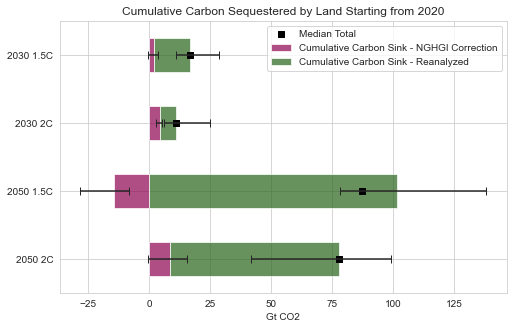

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sequestration_plot(pdata, order=variables, legend={'loc': 'best'}, ax=ax)
ax.set_title('Cumulative Carbon Sequestered by Land Starting from 2020')
ax.set_xlabel('Gt CO2')
ax.set_ylabel('')

## Figures for SI

In [17]:
variables = ['Non-intact Forest Sink - NGHGI Correction', 'Carbon Sequestration|Land Use|Afforestation - Reanalyzed']
hist = [2015, 2020]
future = [2030, 2050, 2070, 2090]
data, pdata = make_sequestration_plot_data(df.filter(variable=variables), variables, categories_to_temp, years=hist + future)
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

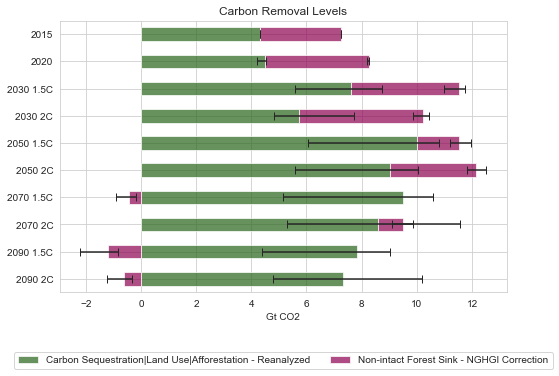

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
sequestration_plot(
    pdata, 
    medians=False, stacked=True, cmap='PiYG_r',
    legend={'loc': 'best'}, ax=ax,
)
ax.set_title('Carbon Removal Levels')
ax.set_xlabel('Gt CO2') 
ax.set_ylabel('')
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['bottom'])

# Panel 1D

In [19]:
variables = ['Total CDR', 'Land CDR']
hist = [2015, 2020]
data, pdata = make_sequestration_plot_data(df.filter(variable=variables), variables, categories_to_temp, years=hist + [2030, 2050])
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

In [20]:
color_map = {
    'Total CDR': '#33701a',
    'Land CDR': '#a3176d', 
}
pyam.run_control().update({'color': {'variable': color_map}})

Text(0, 0.5, '')

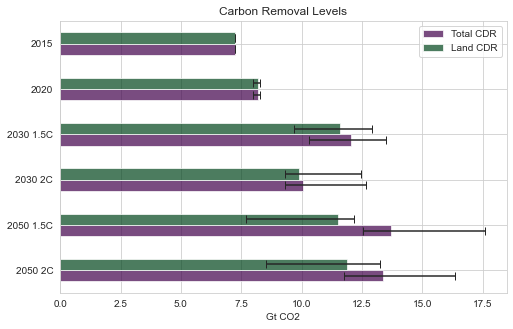

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
sequestration_plot(
    pdata, 
    medians=False, stacked=False, order=['Total CDR', 'Land CDR'], cmap='PRGn',
    legend={'loc': 'best'}, ax=ax,
)
ax.set_title('Carbon Removal Levels')
ax.set_xlabel('Gt CO2') 
ax.set_ylabel('')

In [22]:
reported_data = (pdata - pdata.loc['2020']).round(decimals=1)
reported_data

scenario  quantile_0.25           quantile_0.5           quantile_0.75  \
variable       Land CDR Total CDR     Land CDR Total CDR      Land CDR   
index                                                                    
2050 2C             0.5       3.8          3.7       5.2           5.0   
2050 1.5C          -0.3       4.5          3.3       5.5           3.9   
2030 2C             1.3       1.3          1.7       1.9           4.2   
2030 1.5C           1.7       2.3          3.4       3.9           4.7   
2020                0.0       0.0          0.0       0.0           0.0   
2015               -0.8      -0.8         -0.9      -0.9          -1.0   

scenario             
variable  Total CDR  
index                
2050 2C         8.1  
2050 1.5C       9.3  
2030 2C         4.4  
2030 1.5C       5.2  
2020            0.0  
2015           -1.0

In [23]:
reordered = reported_data.reorder_levels(['variable', 'scenario'], axis=1)
reordered['Land CDR'] / reordered['Total CDR']

scenario,quantile_0.25,quantile_0.5,quantile_0.75
index,,,
2050 2C,0.131579,0.711538,0.617284
2050 1.5C,-0.066667,0.600000,0.419355
2030 2C,1.000000,0.894737,0.954545
2030 1.5C,0.739130,0.871795,0.903846
2020,NaN,NaN,NaN
2015,1.000000,1.000000,1.000000
